In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import keras
import h5py
import PIL
%matplotlib inline
from nltk import word_tokenize as tokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

/home/ftrucco/envs/ml_deeplearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /home/ftrucco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [95]:
df = pd.read_csv("../yelp.csv")
SEED = 40

# Predicting Yelp reviews stars
## Data exploration and analysis
### Data volumetry

In [3]:
df.shape

(10000, 10)

In [4]:
df.head()

business_id        date               review_id  stars  \
0  9yKzy9PApeiPPOUJEtnvkg  2011-01-26  fWKvX83p0-ka4JS3dc6E5A      5   
1  ZRJwVLyzEJq1VAihDhYiow  2011-07-27  IjZ33sJrzXqU-0X6U8NwyA      5   
2  6oRAC4uyJCsJl1X0WZpVSA  2012-06-14  IESLBzqUCLdSzSqm0eCSxQ      4   
3  _1QQZuf4zZOyFCvXc0o6Vg  2010-05-27  G-WvGaISbqqaMHlNnByodA      5   
4  6ozycU1RpktNG2-1BroVtw  2012-01-05  1uJFq2r5QfJG_6ExMRCaGw      5   

                                                text    type  \
0  My wife took me here on my birthday for breakf...  review   
1  I have no idea why some people give bad review...  review   
2  love the gyro plate. Rice is so good and I als...  review   
3  Rosie, Dakota, and I LOVE Chaparral Dog Park!!...  review   
4  General Manager Scott Petello is a good egg!!!...  review   

                  user_id  cool  useful  funny  
0  rLtl8ZkDX5vH5nAx9C3q5Q     2       5      0  
1  0a2KyEL0d3Yb1V6aivbIuQ     0       0      0  
2  0hT2KtfLiobPvh6cDC8JQg     0       1      0  
3  uZetl9T0NcROGOyFfughhg     1       2      0  
4  vYmM4KTsC8ZfQBg-j5MWkw     0       0      0

### Variable analysis

In [5]:
df.describe(include='all')

# Las variables (business_id, review_id, text, type, user_id,) son de tipo string
# La var date es de tipo date
# Las vars stars, cool, useful y funny son de tipo float

business_id        date               review_id  \
count                    10000       10000                   10000   
unique                    4174        1995                   10000   
top     ntN85eu27C04nwyPa8IHtw  2011-03-28  XUlXz5ovpIOgOuAcYIcFuw   
freq                        37          21                       1   
mean                       NaN         NaN                     NaN   
std                        NaN         NaN                     NaN   
min                        NaN         NaN                     NaN   
25%                        NaN         NaN                     NaN   
50%                        NaN         NaN                     NaN   
75%                        NaN         NaN                     NaN   
max                        NaN         NaN                     NaN   

               stars                                               text  \
count   10000.000000                                              10000   
unique           NaN                                               9998   
top              NaN  This review is for the chain in general. The l...   
freq             NaN                                                  2   
mean        3.777500                                                NaN   
std         1.214636                                                NaN   
min         1.000000                                                NaN   
25%         3.000000                                                NaN   
50%         4.000000                                                NaN   
75%         5.000000                                                NaN   
max         5.000000                                                NaN   

          type                 user_id          cool        useful  \
count    10000                   10000  10000.000000  10000.000000   
unique       1                    6403           NaN           NaN   
top     review  fczQCSmaWF78toLEmb0Zsw           NaN           NaN   
freq     10000                      38           NaN           NaN   
mean       NaN                     NaN      0.876800      1.409300   
std        NaN                     NaN      2.067861      2.336647   
min        NaN                     NaN      0.000000      0.000000   
25%        NaN                     NaN      0.000000      0.000000   
50%        NaN                     NaN      0.000000      1.000000   
75%        NaN                     NaN      1.000000      2.000000   
max        NaN                     NaN     77.000000     76.000000   

               funny  
count   10000.000000  
unique           NaN  
top              NaN  
freq             NaN  
mean        0.701300  
std         1.907942  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max        57.000000

### NaN count by variable

In [8]:
for col in df:
    print("Column: {}. NaN Count: {}".format(col, df[col].isnull().sum()))
    
## No hay valores nulos en ninguna variable

Column: business_id. NaN Count: 0
Column: date. NaN Count: 0
Column: review_id. NaN Count: 0
Column: stars. NaN Count: 0
Column: text. NaN Count: 0
Column: type. NaN Count: 0
Column: user_id. NaN Count: 0
Column: cool. NaN Count: 0
Column: useful. NaN Count: 0
Column: funny. NaN Count: 0


### Output variable distribution

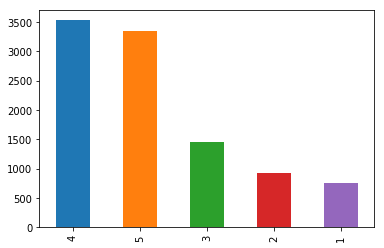

In [9]:
df_stars = df['stars']
df_stars.value_counts().plot.bar()

## Preprocessing
### Cleaning inputs

In [10]:
comments = pd.DataFrame({'content': df.text, 'stars': df.stars})
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

comments = standardize_text(comments, "content")

comments.to_csv("clean_data.csv")
comments.head()

content  stars
0  my wife took me here on my birthday for breakf...      5
1  i have no idea why some people give bad review...      5
2  love the gyro plate  rice is so good and i als...      4
3  rosie, dakota, and i love chaparral dog park!!...      5
4  general manager scott petello is a good egg!!!...      5

In [11]:
clean_comments = comments
clean_comments.tail()

content  stars
9995  first visit   had lunch here today   used my g...      3
9996  should be called house of deliciousness!\n\ni ...      4
9997  i recently visited olive and ivy for business ...      4
9998  my nephew just moved to scottsdale recently so...      2
9999  4 5 locations   all 4 5 star average   i think...      5

### Tokenization

In [12]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

clean_comments["tokens"] = clean_comments["content"].apply(tokenizer.tokenize)
clean_comments.head()

content  stars  \
0  my wife took me here on my birthday for breakf...      5   
1  i have no idea why some people give bad review...      5   
2  love the gyro plate  rice is so good and i als...      4   
3  rosie, dakota, and i love chaparral dog park!!...      5   
4  general manager scott petello is a good egg!!!...      5   

                                              tokens  
0  [my, wife, took, me, here, on, my, birthday, f...  
1  [i, have, no, idea, why, some, people, give, b...  
2  [love, the, gyro, plate, rice, is, so, good, a...  
3  [rosie, dakota, and, i, love, chaparral, dog, ...  
4  [general, manager, scott, petello, is, a, good...

### Stemming and deleting stop words 

In [115]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), \
                             ('tfidf', TfidfTransformer()), \
                             #('mnb', MultinomialNB(fit_prior=False)),
                             ('log', LogisticRegression()), 
                            ])

text_mnb_stemmed = text_mnb_stemmed.fit(df_train.content, df_train.stars)
predicted_mnb_stemmed = text_mnb_stemmed.predict(df_train.content)
predicted_mnb_stemmed_test = text_mnb_stemmed.predict(df_test.content)
np.mean(predicted_mnb_stemmed == df_train.stars)
np.mean(predicted_mnb_stemmed_test == df_test.stars)

AttributeError: 'DataFrame' object has no attribute 'content'

In [107]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    
    accuracy, precision, recall, f1 = get_metrics(y_train, y_train_predicted)
    print("="*10 + " TRAIN " + "="*10)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f \n" % (accuracy, precision, recall, f1))
    
    accuracy, precision, recall, f1 = get_metrics(y_test, y_test_predicted)
    print("="*10 + " TEST " + "="*10)
    print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f \n" % (accuracy, precision, recall, f1))
    
    return y_train_predicted, y_test_predicted

In [1]:
def tfidf(data):
    tfidf_transform = TfidfTransformer()

    train = tfidf_transform.fit(data)
    
    return train, tfidf_transform

X_train_tfidf, tfidf_transform = tfidf(X_train_counts)
X_test_tfidf = tfidf_transform.transform(X_test)

NameError: name 'X_train_counts' is not defined

In [34]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_train_tfidf, y_test_tfidf = evaluate_model(clf_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test)

========== TRAIN ==========
accuracy = 0.995, precision = 0.995, recall = 0.995, f1 = 0.995 

========== TEST ==========
accuracy = 0.514, precision = 0.516, recall = 0.514, f1 = 0.515 



In [62]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=20, random_state=40)
clf.fit(X=X_train_tfidf, y=y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=40, verbose=0, warm_start=False)

In [63]:
evaluate_model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

========== TRAIN ==========
accuracy = 0.686, precision = 0.752, recall = 0.686, f1 = 0.668 

========== TEST ==========
accuracy = 0.417, precision = 0.439, recall = 0.417, f1 = 0.361 



(array([4, 4, 4, ..., 4, 4, 5]), array([4, 4, 5, ..., 4, 4, 4]))

In [64]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_counts, y_train)


In [65]:
evaluate_model(clf, X_train_counts, y_train, X_test_counts, y_test)

========== TRAIN ==========
accuracy = 0.753, precision = 0.775, recall = 0.753, f1 = 0.751 

========== TEST ==========
accuracy = 0.481, precision = 0.491, recall = 0.481, f1 = 0.459 



(array([4, 5, 3, ..., 4, 5, 4]), array([4, 4, 5, ..., 4, 4, 4]))

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed_1 = Pipeline([('vect', stemmed_count_vect), \
                             ('tfidf', TfidfTransformer()), \
                             ('mnb', MultinomialNB(fit_prior=False)),
                            ])


In [76]:
text_mnb_stemmed_1 = text_mnb_stemmed_1.fit(X_train, y_train)

evaluate_model(text_mnb_stemmed_1, X_train, y_train, X_test, y_test)

========== TRAIN ==========
accuracy = 0.570, precision = 0.719, recall = 0.570, f1 = 0.498 

========== TEST ==========
accuracy = 0.431, precision = 0.560, recall = 0.431, f1 = 0.357 



(array([4, 5, 4, ..., 4, 5, 4]), array([4, 4, 5, ..., 4, 4, 4]))

## Describing selected Data

In [66]:
df_train = pd.DataFrame({'stars': y_train})
df_test = pd.DataFrame({'stars': y_test})

#################### train labels ####################


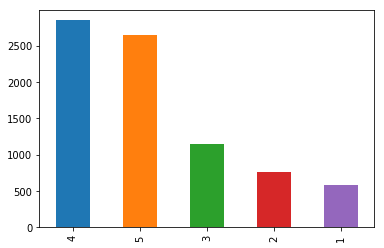

#################### test labels ####################


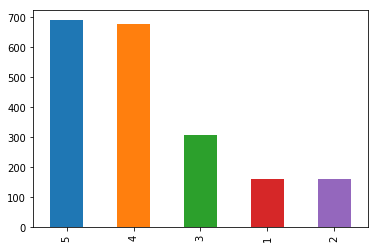

In [67]:
sets = (
    ('train', df_train),
    ('test', df_test)
)

for set_name, set_data in sets:
    print('#' * 20, set_name, 'labels', '#' * 20)
    set_data.stars.value_counts().plot.bar()
    plt.show()

In [20]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

cm = confusion_matrix(y_test, y_predicted_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['1','2','3','4','5'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

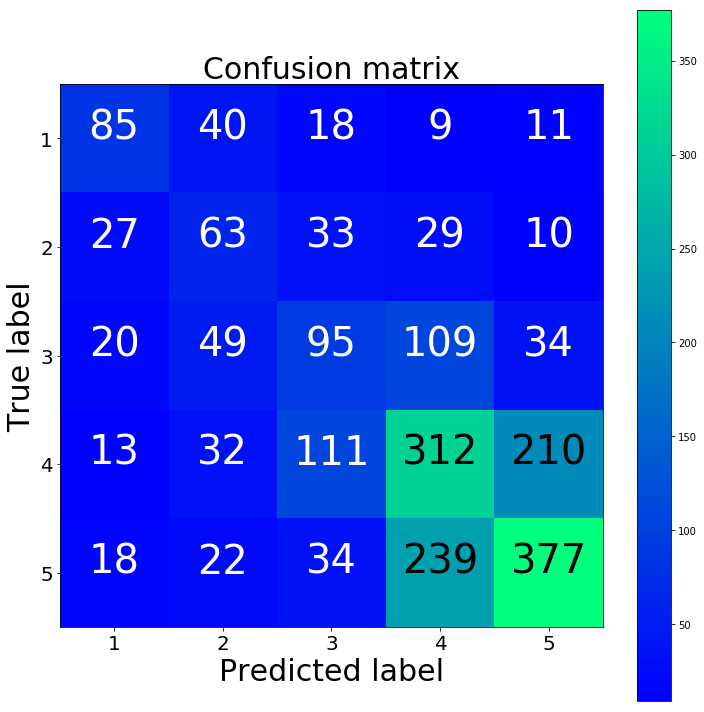

[[ 85  40  18   9  11]
 [ 27  63  33  29  10]
 [ 20  49  95 109  34]
 [ 13  32 111 312 210]
 [ 18  22  34 239 377]]


In [21]:
cm = confusion_matrix(y_test, y_predicted_test)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['1','2','3','4','5'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

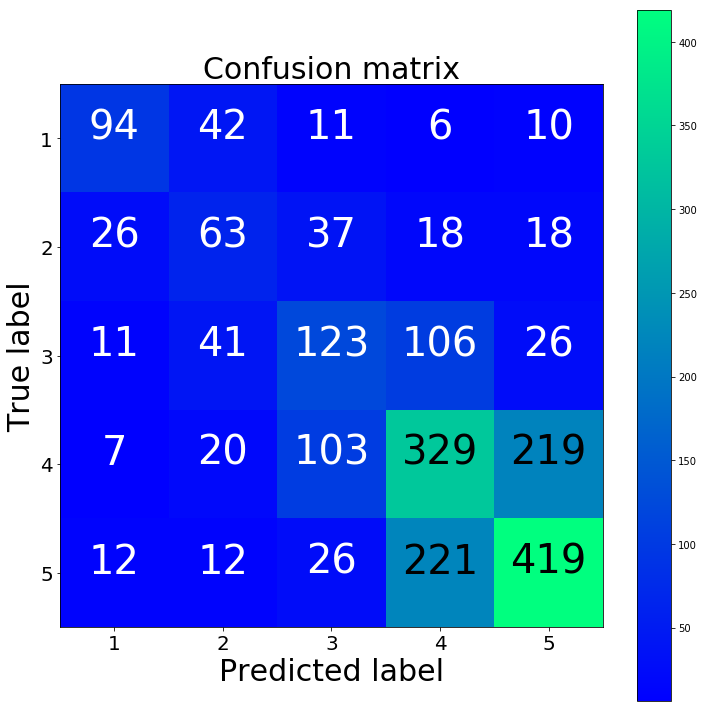

TFIDF confusion matrix
[[ 94  42  11   6  10]
 [ 26  63  37  18  18]
 [ 11  41 123 106  26]
 [  7  20 103 329 219]
 [ 12  12  26 221 419]]
BoW confusion matrix
[[ 85  40  18   9  11]
 [ 27  63  33  29  10]
 [ 20  49  95 109  34]
 [ 13  32 111 312 210]
 [ 18  22  34 239 377]]


In [35]:
cm2 = confusion_matrix(y_test, y_test_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['1','2','3','4','5'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)